*italicized text*#HW2 - Data Exploration and Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import random

params = {"xtick.labelsize" : 18,
          "ytick.labelsize":18,
          "axes.titlesize":18,
          "axes.labelsize":20,
          "legend.fontsize":18,
          "legend.title_fontsize":22,
          "figure.titlesize": 24
          }
pylab.rcParams.update(params)

random.seed(42)

## Loading the dataset

In [2]:
!rm *.csv

from google.colab import files
print("Please load the raw prepared train csv data")
uploadedData = files.upload()
prepared_train_filename = list(uploadedData)[0]

print("Please load the raw prepared test csv data")
uploadedData = files.upload()
prepared_test_filename = list(uploadedData)[0]

rm: cannot remove '*.csv': No such file or directory
Please load the raw prepared train csv data


Saving train_prepared.csv to train_prepared.csv
Please load the raw prepared test csv data


Saving test_prepared.csv to test_prepared.csv


In [3]:
# Data Loading
train_dataset = pd.read_csv(prepared_train_filename)
test_dataset = pd.read_csv(prepared_test_filename)

In [4]:
print(f"train set shape: {train_dataset.shape}")
print(f"test set shape: {test_dataset.shape}")

train set shape: (1000, 26)
test set shape: (250, 26)


In [5]:
train_dataset.columns

Index(['Unnamed: 0', 'patient_id', 'age', 'sex', 'weight', 'current_location',
       'num_of_siblings', 'happiness_score', 'household_income',
       'conversations_per_day', 'sugar_levels', 'sport_activity', 'pcr_date',
       'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07',
       'PCR_08', 'PCR_09', 'PCR_10', 'spread', 'risk', 'SpecialProperty'],
      dtype='object')

In [6]:
# Visualization and basic analysis
# Task: Create a temporary DataFrame containing only PCR_04 and PCR_09
df_train_pcr_04_09 = train_dataset[["PCR_04", "PCR_09"]]
df_train_spread_labels = train_dataset["spread"]

In [7]:
# Q1: train 1-NN model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(df_train_pcr_04_09.values, df_train_spread_labels.values)

KNeighborsClassifier(n_neighbors=1)

In [8]:
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

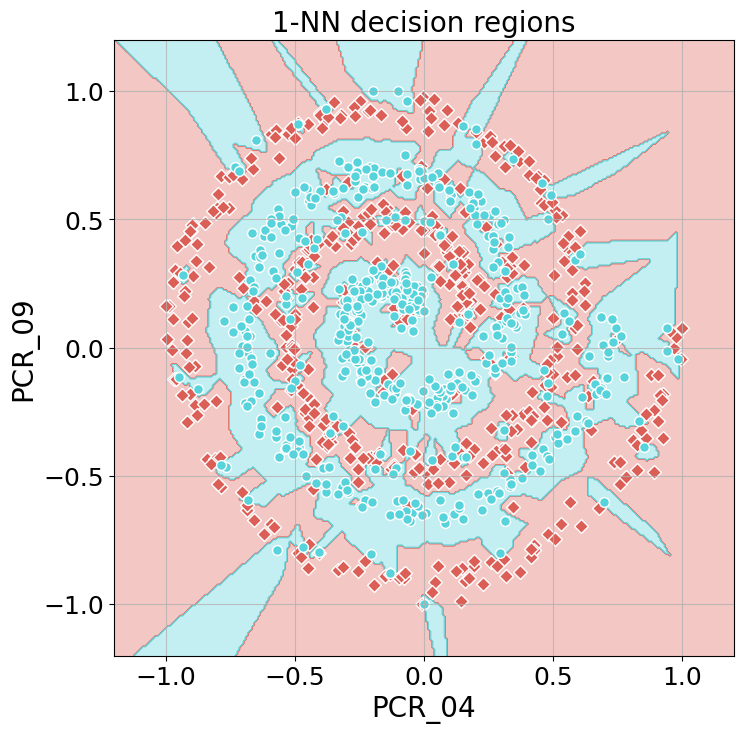

In [9]:
# Q1: Visualize 1-NN decision regions
visualize_clf(knn, df_train_pcr_04_09, df_train_spread_labels, title='1-NN decision regions', xlabel='PCR_04', ylabel='PCR_09')

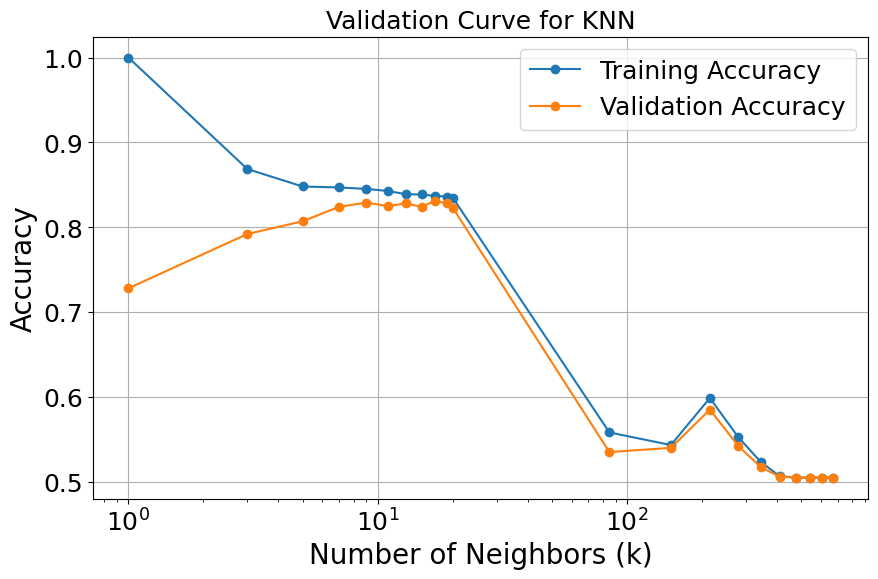

In [10]:
# Q2: use CV to find the best k (number of neighbors)
from sklearn.model_selection import cross_validate

k_values = list(range(1, 20, 2)) + list(range(20, 695, 65))  # predefined by segel
num_folds = 8  # predefined by segel

train_acc = []
validation_acc = []

# for each k value compute train and validation accuracies using CV
for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  cv = cross_validate(knn, df_train_pcr_04_09, df_train_spread_labels, cv=num_folds, return_train_score=True, scoring='accuracy')
  train_acc.append(np.mean(cv['train_score']))
  validation_acc.append(np.mean(cv['test_score']))

# plot the mean training and validation accuracies as a function of k on a log scale
plt.figure(figsize=(10, 6))
plt.semilogx(k_values, train_acc, label='Training Accuracy', marker='o')
plt.semilogx(k_values, validation_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for KNN')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Q2: find the best k (highest validation accuracy)
best_k_index = np.argmax(validation_acc)
best_k = k_values[best_k_index]

print(f'Best k: {best_k}')
print(f'Best k avg training accuracy: {round(train_acc[best_k_index] * 100, 2)}')
print(f'Best k avg validation accuracy: {round(validation_acc[best_k_index] * 100, 2)}')

Best k: 17
Best k avg training accuracy: 83.69
Best k avg validation accuracy: 83.1


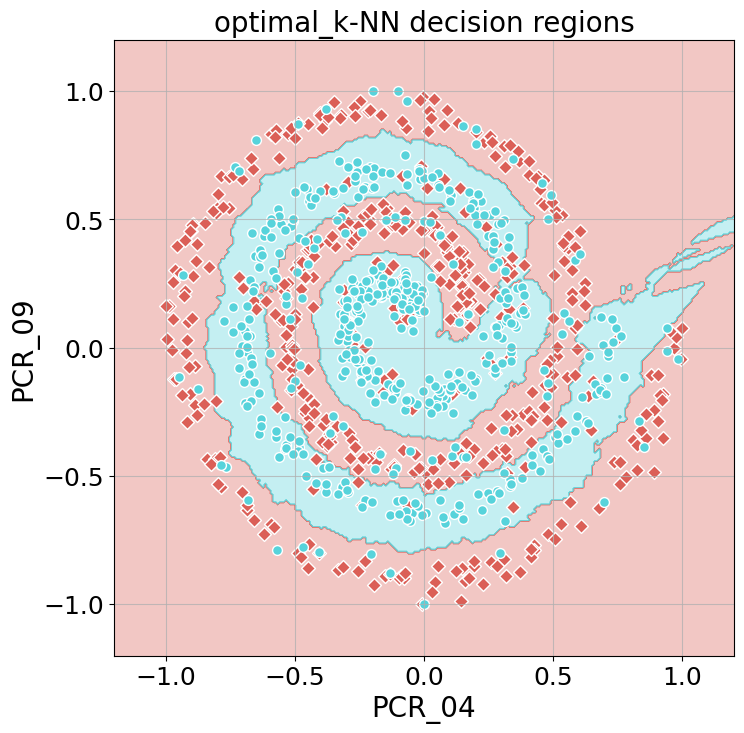

In [13]:
# Q3 retrain the whole train set with the optimal k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(df_train_pcr_04_09.values, df_train_spread_labels.values)

visualize_clf(knn, df_train_pcr_04_09, df_train_spread_labels, title='optimal_k-NN decision regions', xlabel='PCR_04', ylabel='PCR_09')

In [14]:
from sklearn.metrics import accuracy_score

df_test_pcr_04_09 = test_dataset[["PCR_04", "PCR_09"]]
df_test_spread_labels = test_dataset["spread"]

spread_pred = knn.predict(df_test_pcr_04_09.values)
accuracy = accuracy_score(df_test_spread_labels, spread_pred)
print(f'best_k test accuracy: {round(accuracy * 100, 2)}')

best_k test accuracy: 84.4


ID3 depth 3 training accuracy: 67.3


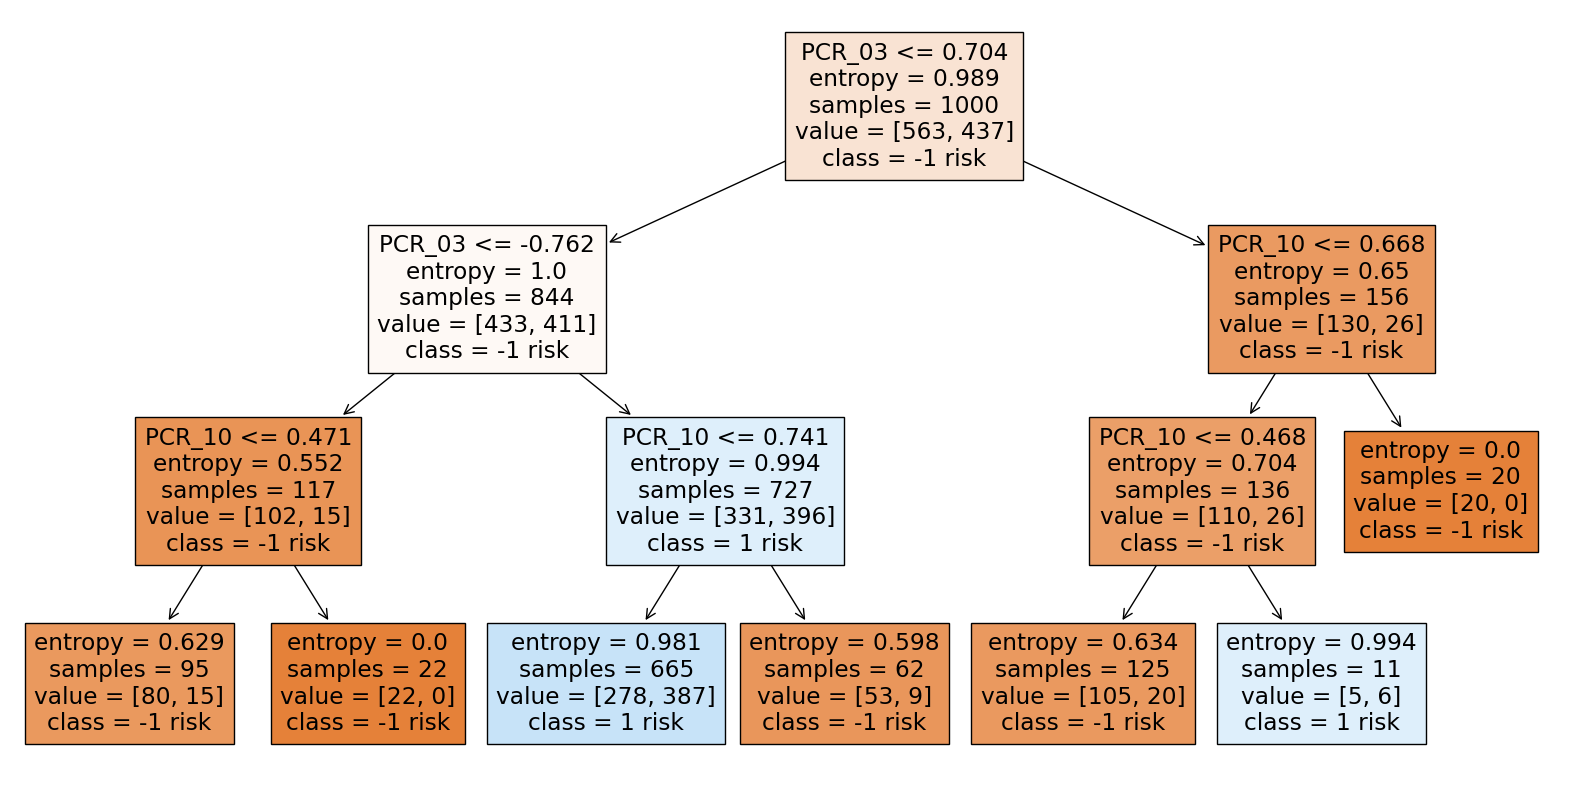

In [19]:
# Q5 Decision tree ID3 with max_depth=3
from sklearn.tree import DecisionTreeClassifier, plot_tree

df_train_pcr_03_10_blood = train_dataset[['PCR_03', 'PCR_10', 'SpecialProperty']]
df_train_risk_labels = train_dataset['risk']

model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(df_train_pcr_03_10_blood, df_train_risk_labels)
risk_pred = model.predict(df_train_pcr_03_10_blood)

train_accuracy = accuracy_score(df_train_risk_labels, risk_pred)
print(f'ID3 depth 3 training accuracy: {round(train_accuracy * 100, 2)}')

# visualize the ID3 tree
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=df_train_pcr_03_10_blood.columns, class_names=[str(cls) + ' risk' for cls in model.classes_], filled=True)
plt.show()

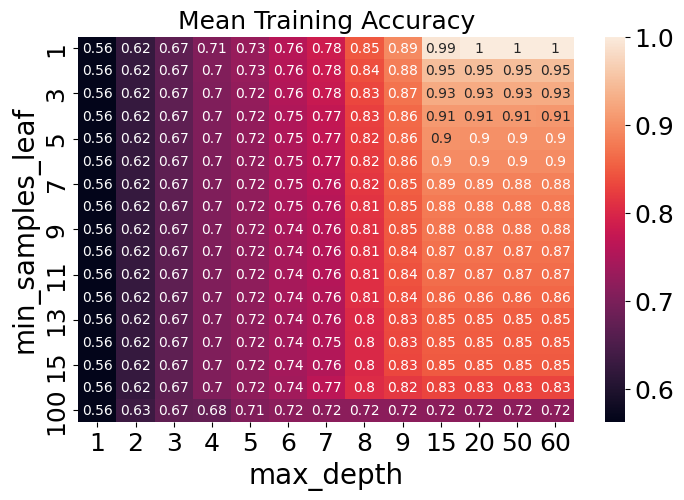

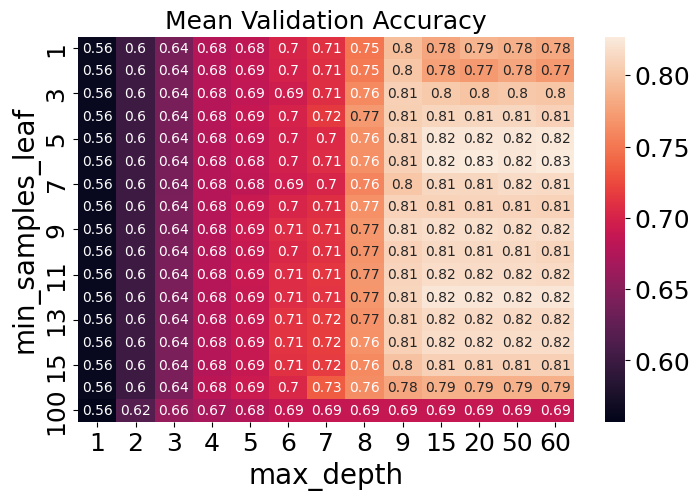

In [22]:
#Q6
from sklearn import model_selection

param_grid = {
    'max_depth': list(range(1, 10)) + [15, 20, 50, 60],
    'min_samples_leaf': list(range(1, 16)) + [20, 100],
}

grid_search = model_selection.GridSearchCV(DecisionTreeClassifier(criterion='entropy'), param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(df_train_pcr_03_10_blood, df_train_risk_labels)

#Visualize
results = grid_search.cv_results_

# Extract relevant data into a DataFrame
data = pd.DataFrame({
    'max_depth': results['param_max_depth'],
    'min_samples_leaf': results['param_min_samples_leaf'],
    'mean_train_score': results['mean_train_score'],
    'mean_test_score': results['mean_test_score']
})
# Reshape the data into a pivot table format for the heatmap
heatmap_data = data.pivot(index='min_samples_leaf', columns='max_depth', values='mean_train_score')

# Create a heatmap using seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True)
plt.xlabel('max_depth')
plt.ylabel('min_samples_leaf')
plt.title('Mean Training Accuracy')
plt.show()

heatmap_data = data.pivot(index='min_samples_leaf', columns='max_depth', values='mean_test_score')

# Create a heatmap using seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True)
plt.xlabel('max_depth')
plt.ylabel('min_samples_leaf')
plt.title('Mean Validation Accuracy')
plt.show()

In [23]:
#Q8:
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

df_test_pcr_03_10_blood = test_dataset[['PCR_03', 'PCR_10', 'SpecialProperty']]
df_test_risk_labels = test_dataset['risk']

test_risk_pred = best_estimator.predict(df_test_pcr_03_10_blood)
test_accuracy = accuracy_score(df_test_risk_labels, test_risk_pred)

print(f"Test Accuracy: {test_accuracy*100}%")
print(f"Best Params {best_params}")

Test Accuracy: 80.4%
Best Params {'max_depth': 20, 'min_samples_leaf': 6}


Part 3: SVM

In [32]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)

        # TODO: complete the loss calculation
        loss = norm**2 + C * np.sum(np.maximum(0, 1-hinge_inputs))  #Element wise max

        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
        f_vector_with_y = np.multiply(np.sign(np.minimum(0, hinge_inputs - 1)), y.reshape(-1, 1)) #if sign is -1, the result is -1. if sign is +1, the result is 0
        g_w = 2*w + C * np.sum(np.multiply(f_vector_with_y, X),axis=0) #Element Wise dot-product
        g_b = C * np.sum(f_vector_with_y)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            # TODO: update the learned parameters correctly
            self.w -= self.lr * g_w
            self.b -= self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        # TODO: compute the predicted labels (+1 or -1)
        margin = (X.dot(self.w) + self.b).reshape(-1, 1)
        y_pred = np.sign(margin)

        return y_pred


In [33]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


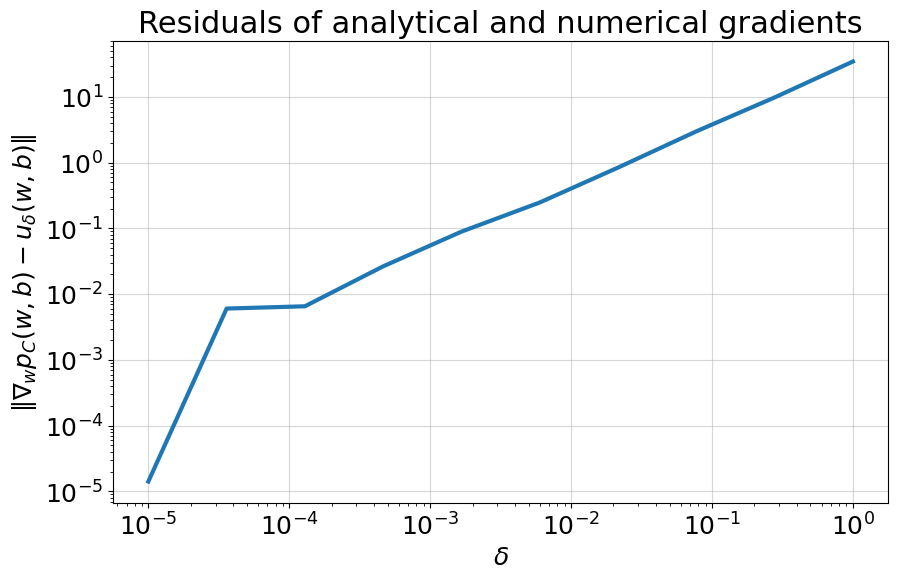

In [34]:
df_train_pcr_04_09 = train_dataset[['PCR_04', 'PCR_09']]
df_train_spread_labels = train_dataset['spread']
X_train, y_train = df_train_pcr_04_09.values, df_train_spread_labels.values
compare_gradients(X_train, y_train, deltas=np.logspace(-5, 0, 10))

lr=1e-11


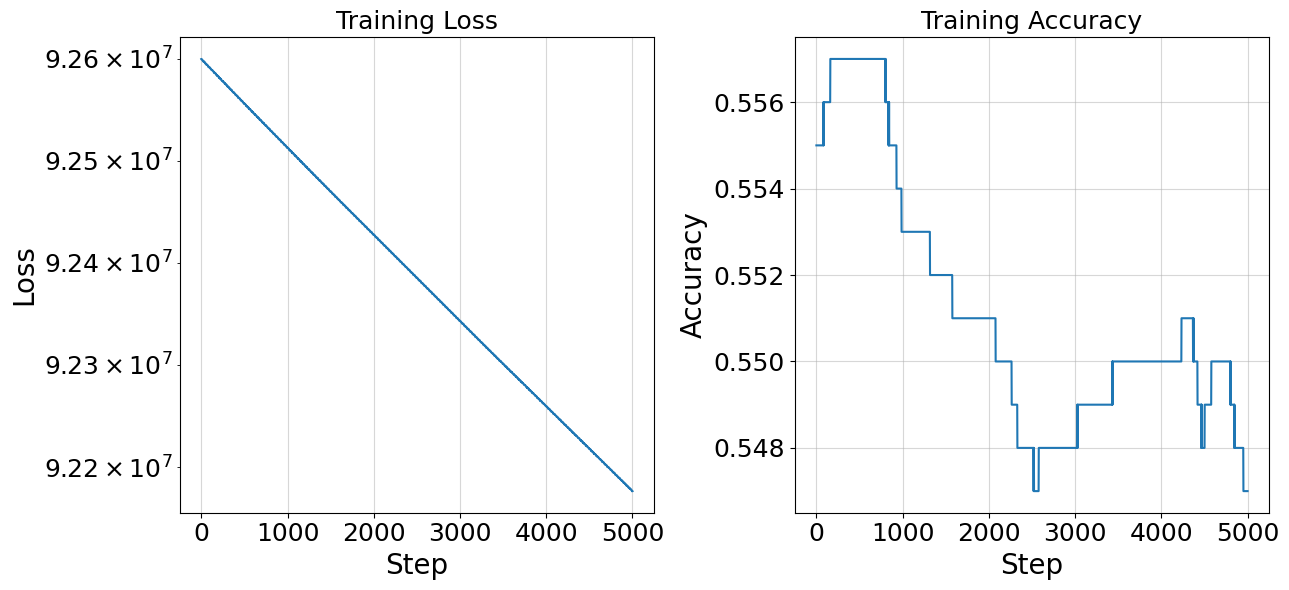

lr=1e-09


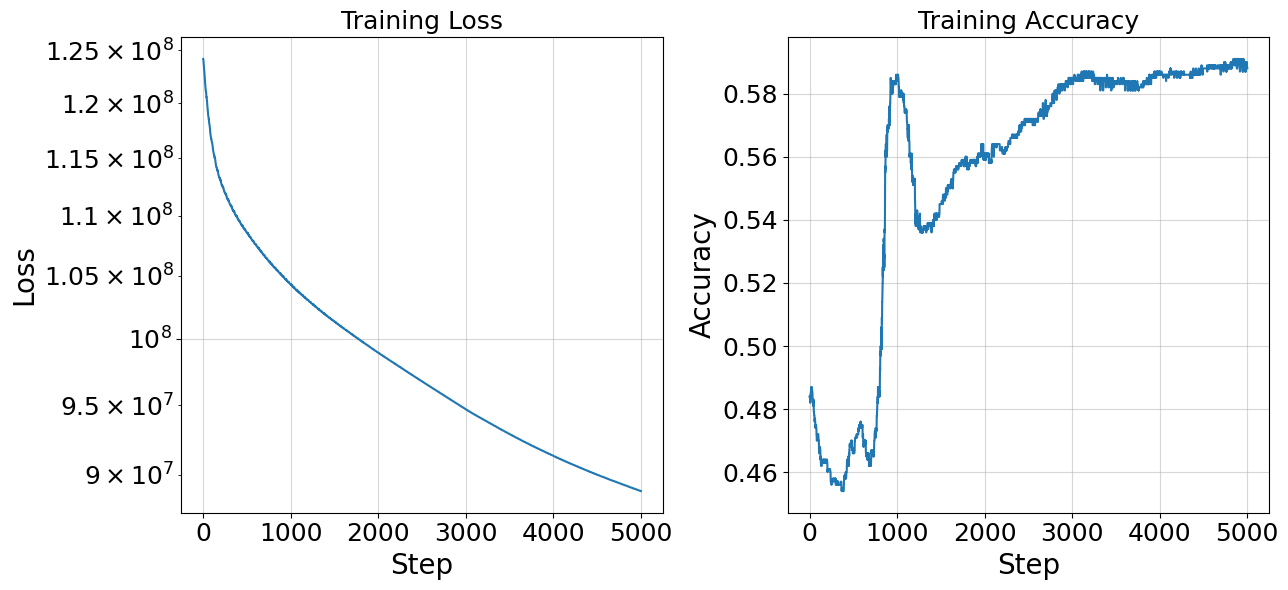

lr=1e-07


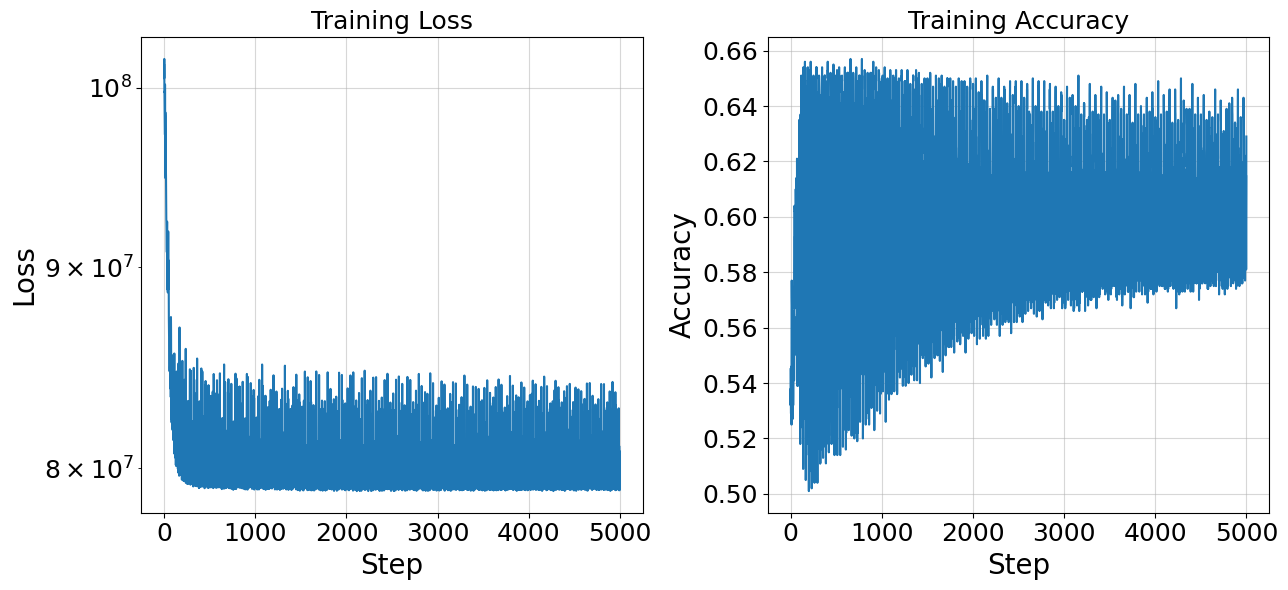

lr=1e-05


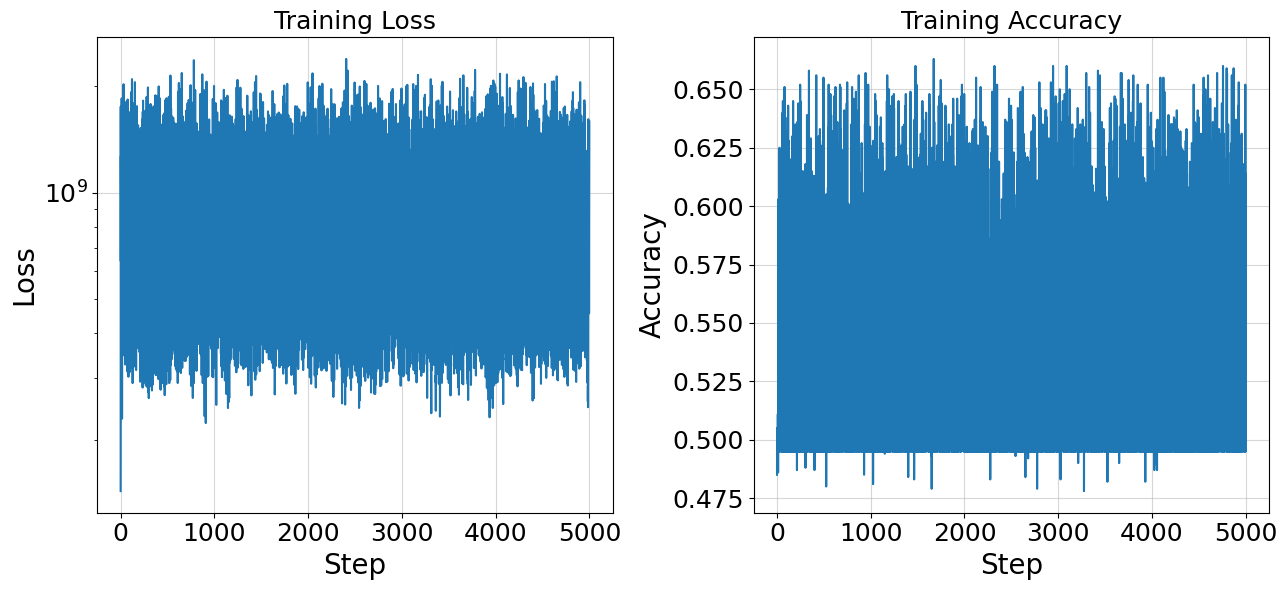

lr=0.001


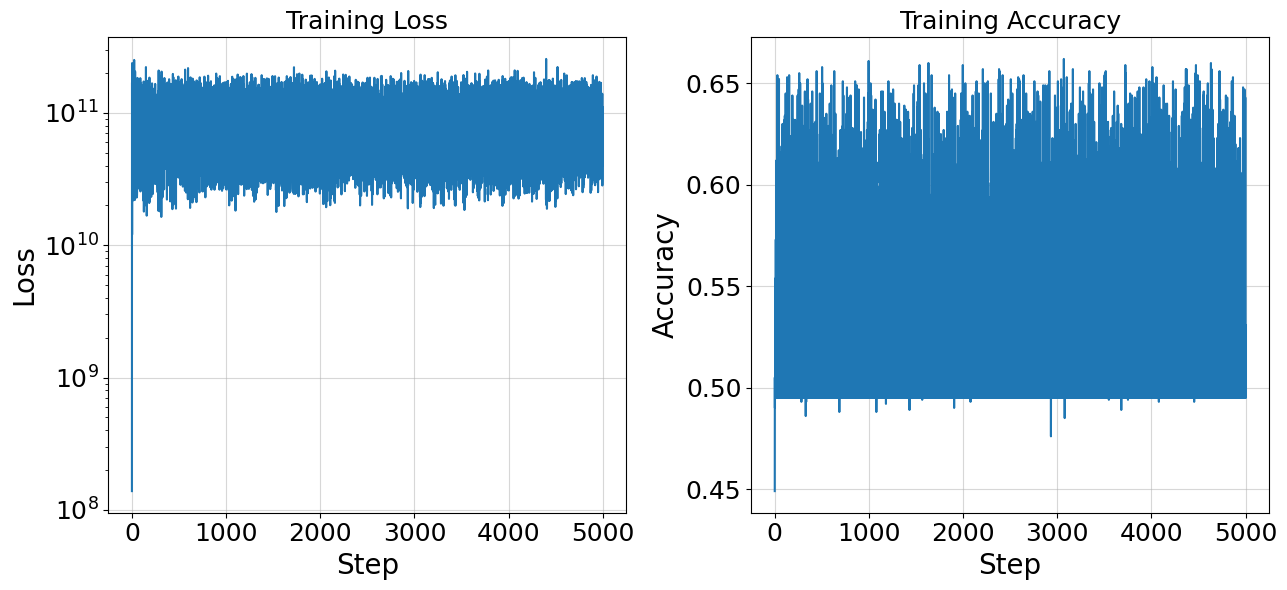

In [ ]:
#Q11

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

for lr in np.logspace(-11, -3, 5):
  C=1e5
  clf = SoftSVM(C=C, lr=lr)
  X_train_poly = PolynomialFeatures(degree=3,).fit_transform(X_train)
  X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)
  losses, accuracies = clf.fit_with_logs(X_train_poly, y_train, max_iter=5000)
  plt.figure(figsize=(13, 6))
  plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Training Loss")
  plt.semilogy(losses), plt.xlabel("Step"), plt.ylabel("Loss")
  plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Training Accuracy")
  plt.plot(accuracies), plt.xlabel("Step"), plt.ylabel("Accuracy")
  plt.tight_layout()
  print(f"lr={lr}")
  plt.show()

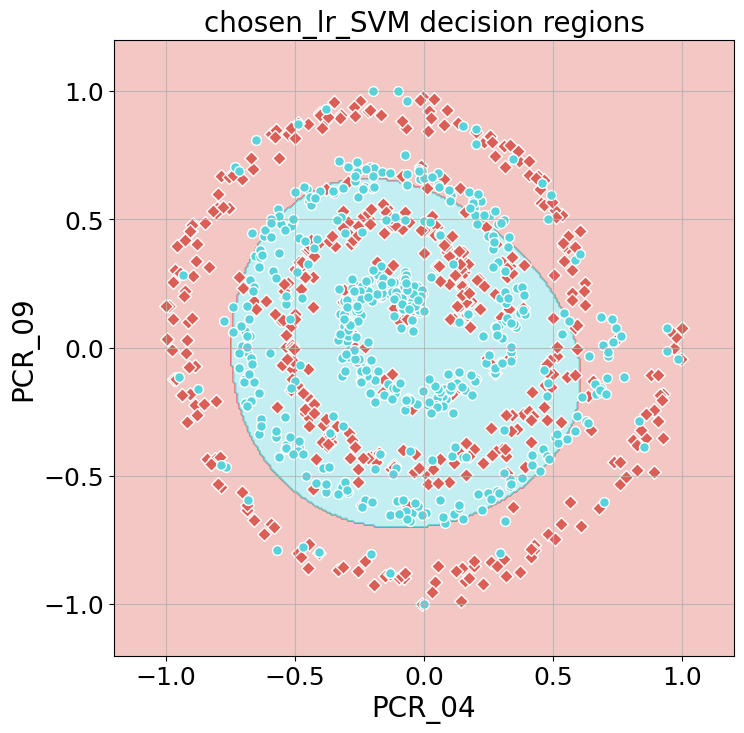

Accuracy Train: 60.699999999999996%
Accuracy Test: 64.8%


In [40]:
#Q12
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=3,)),
('scaler', MinMaxScaler()),
('SVM', SoftSVM(C=1e5, lr=1e-7))])
svm_clf.fit(X_train, y_train)

visualize_clf(svm_clf, df_train_pcr_04_09, df_train_spread_labels, title='chosen_lr_SVM decision regions', xlabel='PCR_04', ylabel='PCR_09')

df_test_pcr_04_09 = test_dataset[['PCR_04', 'PCR_09']]
df_test_spread_labels = test_dataset['spread']

train_spread_pred = svm_clf.predict(df_train_pcr_04_09.values)
test_spread_pred = svm_clf.predict(df_test_pcr_04_09.values)

print(f"Accuracy Train: {accuracy_score(df_train_spread_labels, train_spread_pred)*100}%")
print(f"Accuracy Test: {accuracy_score(df_test_spread_labels, test_spread_pred)*100}%")

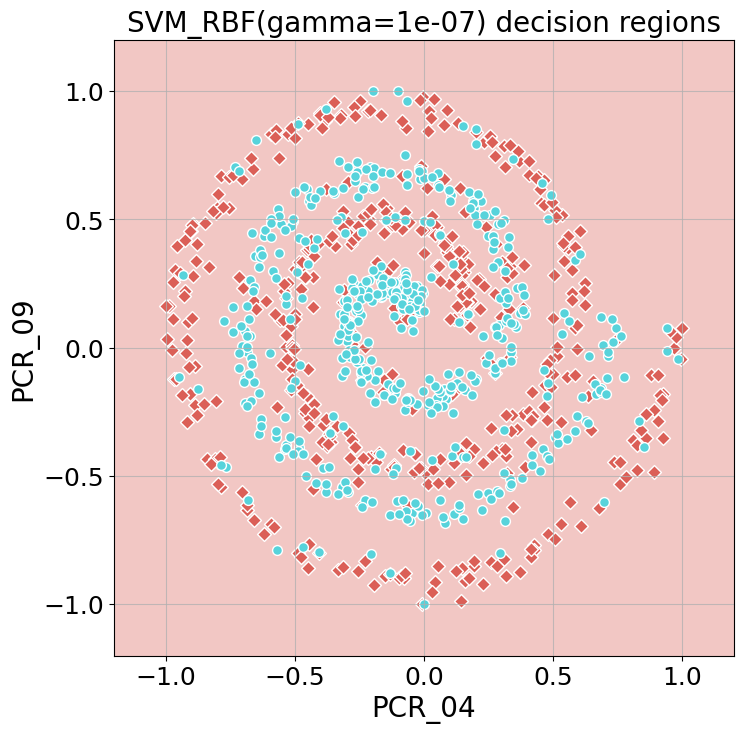

Accuracy Train: 50.5%
Accuracy Test: 48.0%


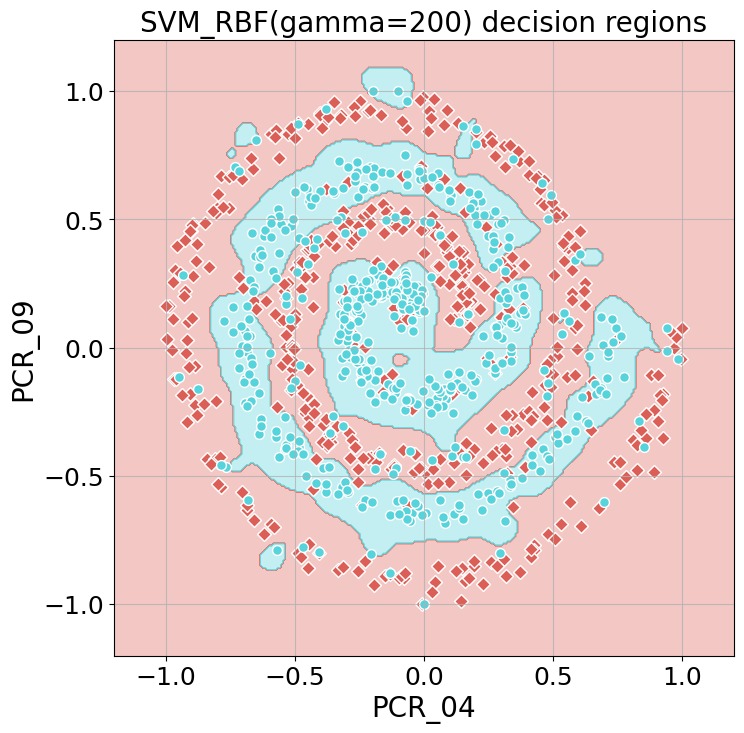

Accuracy Train: 85.9%
Accuracy Test: 82.0%


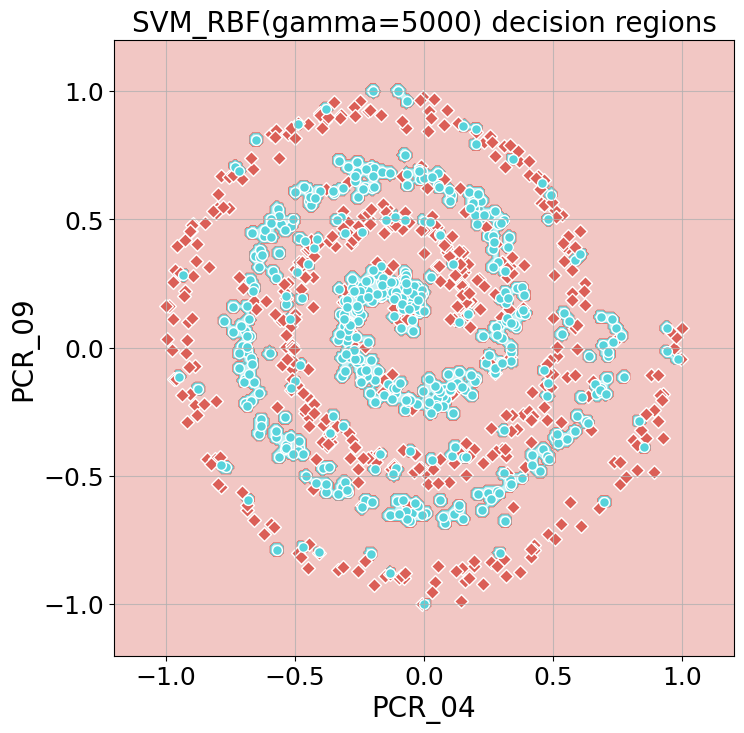

Accuracy Train: 98.5%
Accuracy Test: 68.4%


In [42]:
#Q14

from sklearn.svm import SVC

df_train_pcr_04_09 = train_dataset[['PCR_04', 'PCR_09']]
df_train_spread_labels = train_dataset['spread']

def do_SVC_gamma(gamma):
  model = SVC(C=1.0, kernel='rbf', gamma=gamma)
  model.fit(df_train_pcr_04_09.values, df_train_spread_labels.values)

  visualize_clf(model, df_train_pcr_04_09, df_train_spread_labels, title=f'SVM_RBF(gamma={gamma}) decision regions', xlabel='PCR_04', ylabel='PCR_09')

  train_spread_pred = model.predict(df_train_pcr_04_09.values)
  test_spread_pred = model.predict(df_test_pcr_04_09.values)
  print(f"Accuracy Train: {accuracy_score(df_train_spread_labels, train_spread_pred)*100}%")
  print(f"Accuracy Test: {accuracy_score(df_test_spread_labels, test_spread_pred)*100}%")

do_SVC_gamma(1e-7)
do_SVC_gamma(200)
do_SVC_gamma(5000)

# How to download from Colab?

In [ ]:
from google.colab import files
outputPath = "saved_file.csv"
dataset.to_csv(outputPath)
files.download(outputPath)